<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-3-public/blob/main/Course%201%20-%20Custom%20Models%2C%20Layers%20and%20Loss%20Functions/Week%204%20-%20Models/C1_W4_Lab_2_resnet-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Implementing ResNet

In this lab, you will continue exploring Model subclassing by building a more complex architecture. 

[Residual Networks](https://arxiv.org/abs/1512.03385) make use of skip connections to make deep models easier to train. 
- There are branches as well as many repeating blocks of layers in this type of network. 
- You can define a model class to help organize this more complex code, and to make it easier to re-use your code when building the model.
- As before, you will inherit from the [Model class](https://keras.io/api/models/model/) so that you can make use of the other built-in methods that Keras provides.

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

## Implement Model subclasses

As shown in the lectures, you will first implement the Identity Block which contains the skip connections (i.e. the `add()` operation below. This will also inherit the Model class and implement the `__init__()` and `call()` methods.

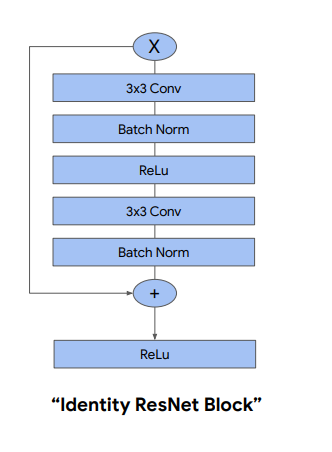

In [2]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

From there, you can build the rest of the ResNet model. 
- You will call your `IdentityBlock` class two times below and that takes care of inserting those blocks of layers into this network.

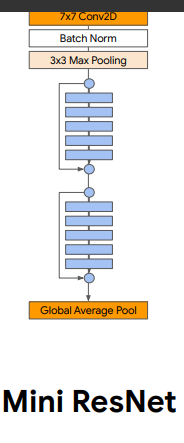

In [3]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

## Training the Model

As mentioned before, inheriting the Model class allows you to make use of the other APIs that Keras provides, such as:
- training
- serialization
- evaluation

You can instantiate a Resnet object and train it as usual like below:

**Note**: If you have issues with training in the Coursera lab environment, you can also run this in Colab using the "open in colab" badge link.

In [4]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

1875/1875 [==============================] - 269s 143ms/step - loss: 0.1278 - accuracy: 0.9662
